# Linear Regression - Least Squares  

-------------  

_Code by PJ Csbrera_  

## Table of Contents
----------------  
- [Project Overview](#overview)
- [Introduction and Review](#intro)
- [Data Exploration](#data)  
- [Coding Linear Regression](#code)

<a id = "overview"></a>
## Overview
----------

This notebook contains a from scratch implementation of least squares regression in `Python`. After a brief review of the algorithm, there are a number of functions that will read in raw data with `Pandas` and perform a least squares regression on a subset of that data.

This will include:  
- Calculating least squares weights
- reading data to return a `Pandas` DataFrame  
- select data by column  
- implement column cutoffs

**Problem**: Using housing data, we will attempt to predict house price using living area with a regression model.  

**Data**: Our data today comes from [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).  

See above link for Description of data from `Kaggle`.  

<a id = "intro"></a>
### Introduction and Review

As long as a few basic assumptions are fulfilled, linear regression using least squares is solvable exactly, without requiring approximation. 

We will use the matrix version of the least squares solution to derive the desired result. As a reminder, this expresses the least squares coefficients $w_{LS}$ as a vector, and calculates that vector as a function of $X$, the matrix of inputs, and $y$, the vector of outputs from the training set:

$$w_{LS} = (X^T X)^{−1}X^T y,$$

where $w_{LS}$ refers to the vector of weights we are trying to find, $X$ is the matrix of inputs, and $y$ is the output vector. 

In this equation, $X$ is always defined to have a vector of $1$ values as its first column. In other words, even when there is only one input value for each data point, $X$ takes the form:

$$
X = \begin{bmatrix}
1 \  x_{11}  \\
1 \  x_{21}  \\
\vdots \ \vdots \\
1 \ x_{n1}
\end{bmatrix} 
$$

For two inputs per data point, $X$ will take this form:
 
$$
X = \begin{bmatrix}
1 \  x_{11} \  x_{12} \\
1 \  x_{21} \  x_{22} \\
\vdots \ \vdots \\
1 \ x_{n1} \  x_{n2}
\end{bmatrix} 
$$


<a id = "data"></a>
### Data Exploration

Before coding an algorithm, we will take a look at our data using `Pandas`. For visualizations we'll use `matplotlib`.

In [2]:
### This cell imports the necessary modules and sets a few plotting parameters for display

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
### Read in the data
tr_path = './house-prices/train.csv'
test_path = './house-prices/test.csv'
data = pd.read_csv(tr_path)

In [4]:
### The .head() function shows the first few lines of data for perspecitve
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
### Lists column names
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Visualizations

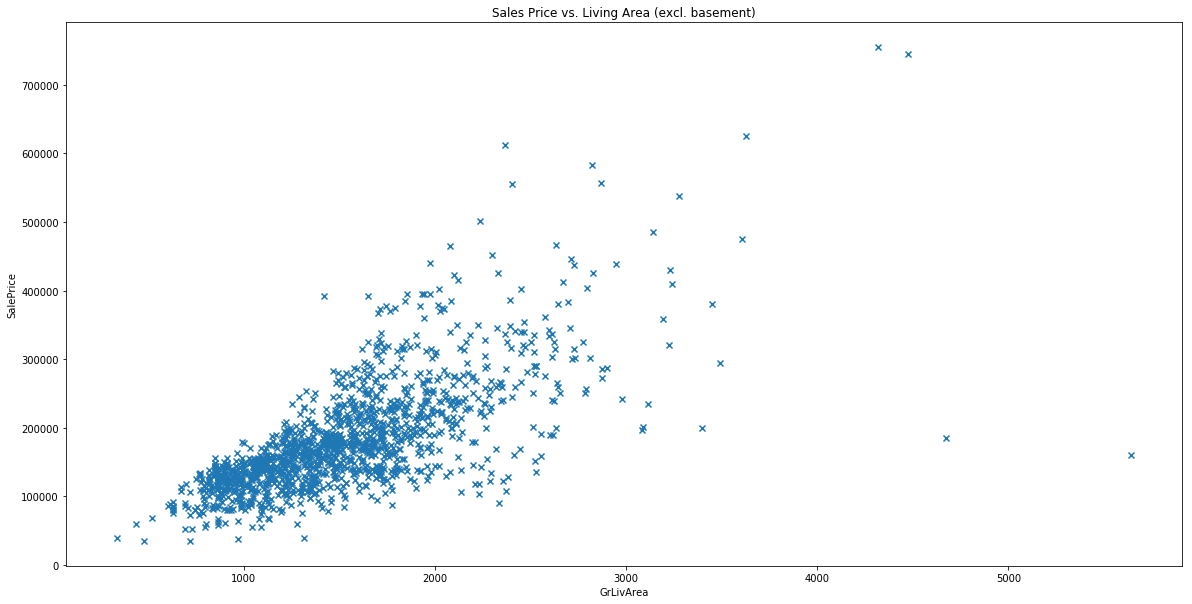

In [6]:
### We can plot the data as follows
### Price v. living area
### with matplotlib

Y = data['SalePrice']
X = data['GrLivArea']

plt.scatter(X, Y, marker = "x")

### Annotations
plt.title("Sales Price vs. Living Area (excl. basement)")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice");

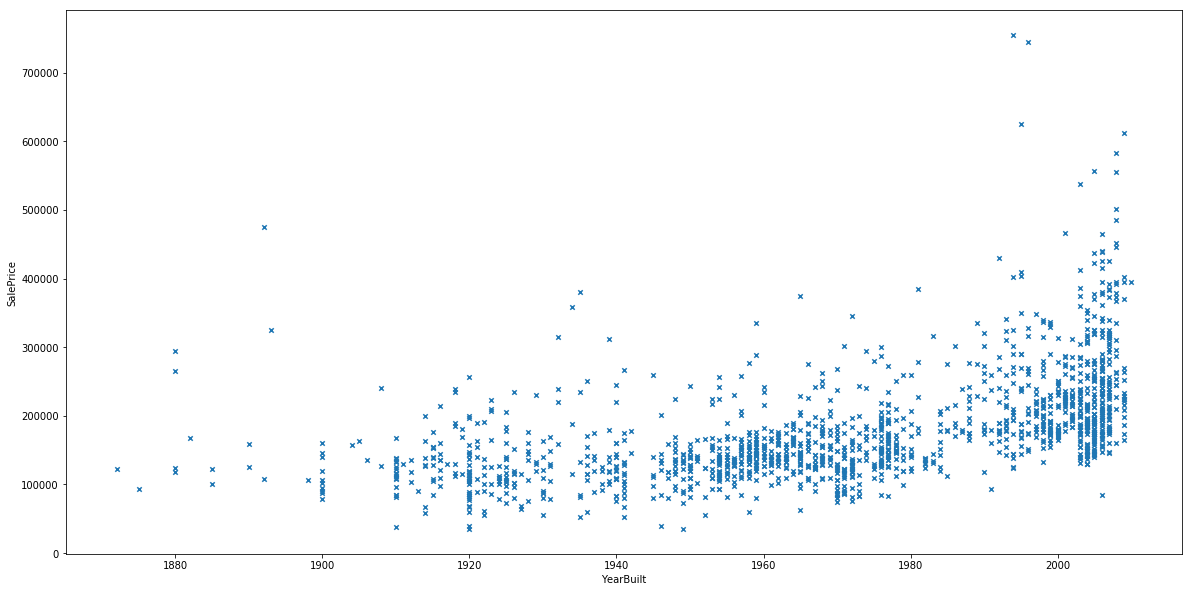

In [7]:
### price v. year
### Using Pandas

data.plot('YearBuilt', 'SalePrice', kind = 'scatter', marker = 'x');

<a id = "code"></a>
### Coding Linear Regression
Given the equation above for $w_{LS}$, we know all we need to in order to solve a linear regression. Coding out the steps in `Python`, we will complete the process in several steps.

#### Matrix Operations
Below is an example of a function that takes the inverse of a matrix. The `numpy` module is used, and all the function does is call the `numpy` function `np.linalg.inv()`. Though simple, this can be used as a template for a few good coding practices:

* Name functions and parameters descriptively
* Use underscores _ to separate words in variable/function names (snake_case, **NOT** PascalCase or camelCase)
* In functions and classes, include a docstring between triple quotes 

In [8]:
def inverse_of_matrix(mat):
    """Calculate and return the multiplicative inverse of a matrix.
    
    Positional argument:
        mat -- a square matrix to invert
    
    Example:
        sample_matrix = [[1, 2], [3, 4]]
        the_inverse = inverse_of_matrix(sample_matrix)
        
    Requirements:
        This function depends on the numpy function `numpy.linalg.inv`. 
    """
    matrix_inverse = np.linalg.inv(mat)
    return matrix_inverse

### Testing function:

print("test",inverse_of_matrix([[1,2],[3,4]]), "\n")
print("From Data:\n", inverse_of_matrix(data.iloc[:2,:2]))

test [[-2.   1. ]
 [ 1.5 -0.5]] 

From Data:
 [[-0.2   0.6 ]
 [ 0.02 -0.01]]


#### Read Data

In [9]:
def read_to_df(file_path):
    """Read on-disk data and return a dataframe."""
    data = pd.read_csv(file_path)
    return data

#### Select by Columns

In [10]:
def select_columns(data_frame, column_names):
    """Return a subset of a data frame by column names.

    Positional arguments:
        data_frame -- a pandas DataFrame object
        column_names -- a list of column names to select

    Example:
        data = read_into_data_frame('train.csv')
        selected_columns = ['SalePrice', 'GrLivArea', 'YearBuilt']
        sub_df = select_columns(data, selected_columns)
    """
    sub_df = data_frame[column_names]
    return sub_df

#### Subset Data by Value

In [11]:
def column_cutoff(data_frame, cutoffs):
    """Subset data frame by cutting off limits on column values.
    
    Positional arguments:
        data -- pandas DataFrame object
        cutoffs -- list of tuples in the format: 
        (column_name, min_value, max_value)
        
    Example:
        data_frame = read_into_data_frame('train.csv')
        # Remove data points with SalePrice < $50,000
        # Remove data points with GrLiveAre > 4,000 square feet
        cutoffs = [('SalePrice', 50000, 1e10), ('GrLivArea', 0, 4000)]
        selected_data = column_cutoff(data_frame, cutoffs)
    """
    data=data_frame
    for x in cutoffs:
        filters = (data[x[0]] >= x[1]) & (data[x[0]] <= x[2])
        data = data.where(filters)
    data = data.drop(data[np.isnan(data['SalePrice'])].index)
    return data

selected_columns = ['SalePrice', 'GrLivArea', 'YearBuilt']
sub_df = select_columns(data, selected_columns)
cutoffs = [('SalePrice', 50000, 1e10), ('GrLivArea', 0, 4000)]
column_cutoff(sub_df, cutoffs)

,SalePrice,GrLivArea,YearBuilt
0,208500.0,1710.0,2003.0
1,181500.0,1262.0,1976.0
2,223500.0,1786.0,2001.0
3,140000.0,1717.0,1915.0
4,250000.0,2198.0,2000.0
5,143000.0,1362.0,1993.0
6,307000.0,1694.0,2004.0
7,200000.0,2090.0,1973.0
8,129900.0,1774.0,1931.0
9,118000.0,1077.0,1939.0


Next you'll implement the equation above for $w_{LS}$ using the inverse matrix function.  
$$w_{LS} = (X^T X)^{−1}X^T y,$$

#### Least Squares

In [12]:
### Step 1: ensure that the number of rows of each matrix is greater than or equal to the number
### of columns.
### ### If not, transpose the matricies.
### In particular, the y input should end up as a n-by-1 matrix, and the x input as a n-by-p matrix

### Step 2: *prepend* an n-by-1 column of ones to the input_x matrix

### Step 3: Use the above equation to calculate the least squares weights.

### weights = least_squares_weights(train_x, train_y)
### weight1 = weights[0][0]; weight2 = weights[1][0];... weight<n+1> = weights[n][0]

def least_squares_weights(input_x, target_y):
    """Calculate linear regression least squares weights.
    
    Positional arguments:
        input_x -- matrix of training input data
        target_y -- vector of training output values
        
        The dimensions of X and y will be either p-by-n and 1-by-n
        Or n-by-p and n-by-1
        
    Example:
        import numpy as np
        training_y = np.array([[208500, 181500, 223500, 
                                140000, 250000, 143000, 
                                307000, 200000, 129900, 
                                118000]])
        training_x = np.array([[1710, 1262, 1786, 
                                1717, 2198, 1362, 
                                1694, 2090, 1774, 
                                1077], 
                               [2003, 1976, 2001, 
                                1915, 2000, 1993, 
                                2004, 1973, 1931, 
                                1939]])
        weights = least_squares_weights(training_x, training_y)
        
        print(weights)  #--> np.array([[-2.29223802e+06],
                           [ 5.92536529e+01],
                           [ 1.20780450e+03]])
                           
        print(weights[1][0]) #--> 59.25365290008861
        
    Assumptions:
        -- target_y is a vector whose length is the same as the
        number of observations in training_x
    """
    # step 1: transpose input_x or target_y if necessary
    n = input_x.shape[0]
    p = input_x.shape[1]
    y_dimension = target_y.shape[0]
 
    if y_dimension > 1:
        y = target_y
    else:
        y = target_y.transpose()
        y_dimension = y.shape[0]
  
    if n == y_dimension:
        X = input_x
    else:
        X = input_x.transpose()

    # step 2: prepend n-by-1 column of ones to X
    oneses = np.ones(shape=y.shape)
    X = np.concatenate((oneses, X), 1)

    # step 3: calculate weights
    weights = inverse_of_matrix(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    return weights

training_y = np.array([[208500, 181500, 223500, 
                        140000, 250000, 143000, 
                        307000, 200000, 129900, 
                        118000]])
training_x = np.array([[1710, 1262, 1786, 
                        1717, 2198, 1362, 
                        1694, 2090, 1774, 
                        1077], 
                       [2003, 1976, 2001, 
                        1915, 2000, 1993, 
                        2004, 1973, 1931, 
                        1939]])
weights = least_squares_weights(training_x, training_y)

print(weights) #--> [[-2.29223802e+06], 
               #     [ 5.92536529e+01], 
               #     [ 1.20780450e+03]]
print(weights[1][0]) #--> 59.25365290008861

[[-2.29223802e+06]
 [ 5.92536529e+01]
 [ 1.20780450e+03]]
59.25365290008786


#### Testing on Real Data

Now that we have code to read the data and perform matrix operations, we can put it all together to perform linear regression on a data set of our choosing.  

If your functions above are defined correctly, the following two cells should run without error.

In [13]:
df = read_to_df(tr_path)
df_sub = select_columns(df, ['SalePrice', 'GrLivArea', 'YearBuilt'])

cutoffs = [('SalePrice', 50000, 1e10), ('GrLivArea', 0, 4000)]
df_sub_cutoff = column_cutoff(df_sub, cutoffs)

X = df_sub_cutoff['GrLivArea'].values
Y = df_sub_cutoff['SalePrice'].values

### reshaping for input into function
training_y = np.array([Y])
training_x = np.array([X])

weights = least_squares_weights(training_x, training_y)
print(weights)

[[13454.06670576]
 [  110.78992341]]


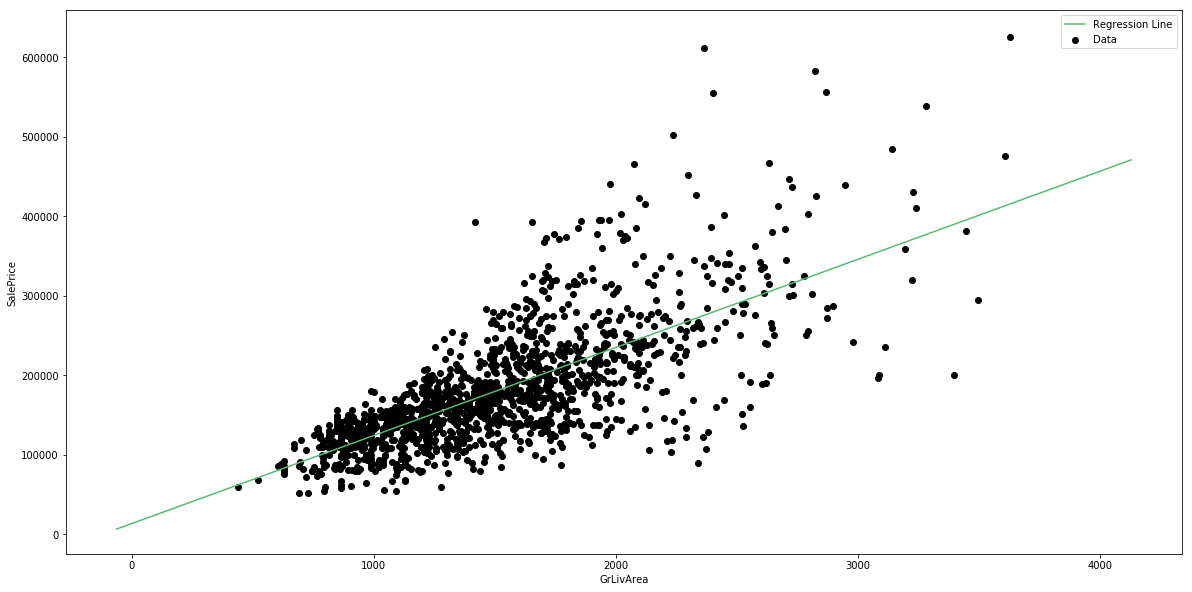

In [14]:
max_X = np.max(X) + 500
min_X = np.min(X) - 500

### Choose points evenly spaced between min_x in max_x
reg_x = np.linspace(min_X, max_X, 1000)

### Use the equation for our line to calculate y values
reg_y = weights[0][0] + weights[1][0] * reg_x

plt.plot(reg_x, reg_y, color='#58b970', label='Regression Line')
plt.scatter(X, Y, c='k', label='Data')

plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

#### Calculating RMSE

In [15]:
rmse = 0

b0 = weights[0][0]
b1 = weights[1][0]

for i in range(len(Y)):
    y_pred = b0 + b1 * X[i]
    rmse += (Y[i] - y_pred) ** 2
rmse = np.sqrt(rmse/len(Y))
print(rmse)

53092.48486948662


#### Calculating $R^2$

In [16]:
ss_t = 0
ss_r = 0

mean_y = np.mean(Y)

for i in range(len(Y)):
    y_pred = b0 + b1 * X[i]
    ss_t += (Y[i] - mean_y) ** 2
    ss_r += (Y[i] - y_pred) ** 2
r2 = 1 - (ss_r/ss_t)

print(r2)

0.5163484562864966


### sklearn implementation

While it is useful to build and program our model from scratch, this course will also introduce how to use conventional methods to fit each model. In particular, we will be using the `scikit-learn` module (also called `sklearn`.)  

Check to see how close your answers are!

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

### sklearn requires a 2-dimensional X and 1 dimensional y. The below yeilds shapes of:
### skl_X = (n,1); skl_Y = (n,)
skl_X = df_sub_cutoff[['GrLivArea']]
skl_Y = df_sub_cutoff['SalePrice']

lr.fit(skl_X,skl_Y)
print("Intercept:", lr.intercept_)
print("Coefficient:", lr.coef_)

Intercept: 13454.066705758654
Coefficient: [110.78992341]
